# Reliance Stock Prediction

### dependent variable = Close Price

### 1. Import required packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

### Read the data from the Source

In [2]:
stock_data = pd.read_csv('reliance_stock_data_(1990-2023).csv')
stock_data

,Date,Price,Open,High,Low,Volume,Change%
0,Jan 02 1990,7.27,7.31,7.44,7.14,0,-1.62%
1,Jan 03 1990,6.92,7.18,7.18,6.84,0,-4.81%
2,Jan 04 1990,6.50,6.24,6.58,6.24,0,-6.07%
3,Jan 05 1990,6.71,6.37,6.71,6.37,0,3.23%
4,Jan 08 1990,6.71,7.05,7.05,6.67,0,0.00%
...,...,...,...,...,...,...,...
8175,Dec 11 2023,2459.05,2452.15,2467.40,2452.15,169.52K,+0.12%
8176,Dec 12 2023,2423.95,2458.00,2464.90,2420.25,98.11K,-1.43%
8177,Dec 13 2023,2433.40,2427.75,2438.00,2406.30,137.30K,+0.39%
8178,Dec 14 2023,2464.50,2453.00,2475.00,2442.70,3.65M,+1.28%


In [3]:
stock_data.isnull().sum()

Date        0
 Price      0
 Open       0
 High       0
 Low        0
 Volume     0
 Change%    0
dtype: int64

In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8180 entries, 0 to 8179
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8180 non-null   object 
 1    Price    8180 non-null   float64
 2    Open     8180 non-null   float64
 3    High     8180 non-null   float64
 4    Low      8180 non-null   float64
 5    Volume   8180 non-null   object 
 6    Change%  8180 non-null   object 
dtypes: float64(4), object(3)
memory usage: 447.5+ KB


In [5]:
# Assuming stock_data is your DataFrame
stock_data.set_index(pd.to_datetime(stock_data['Date']), inplace=True)  # Set 'Date' as index
stock_data.drop(columns=['Date'], inplace=True)  # Drop the 'Date' column

In [6]:
stock_data.columns

Index([' Price', ' Open', ' High', ' Low', ' Volume', ' Change%'], dtype='object')

In [7]:
stock_data = stock_data.rename(columns={' Price':'Price',' Open': 'Open', ' High': 'High', ' Low': 'Low', ' Volume':'Volume',' Change%':'Change%'})

In [8]:
stock_data = stock_data.drop(['Open','High','Low','Volume','Change%'], axis=1)
stock_data

,Price
Date,
1990-01-02,7.27
1990-01-03,6.92
1990-01-04,6.50
1990-01-05,6.71
1990-01-08,6.71
...,...
2023-12-11,2459.05
2023-12-12,2423.95
2023-12-13,2433.40


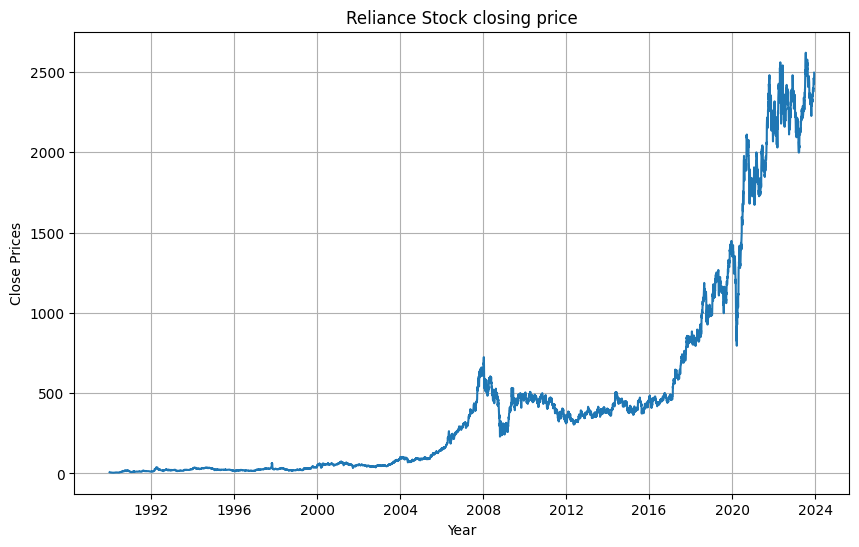

In [9]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Close Prices')
plt.plot(stock_data['Price'])
plt.title('Reliance Stock closing price')
plt.show()

<Axes: >

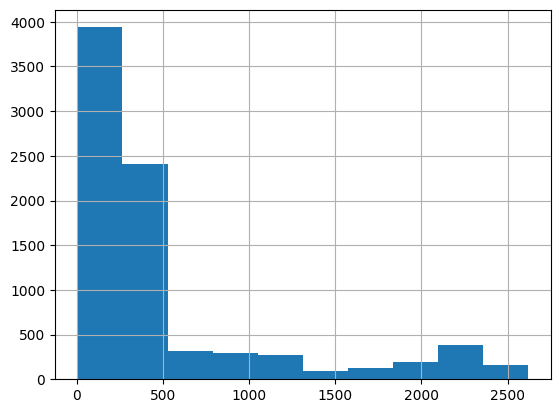

In [10]:
stock_data['Price'].hist()

<Axes: ylabel='Density'>

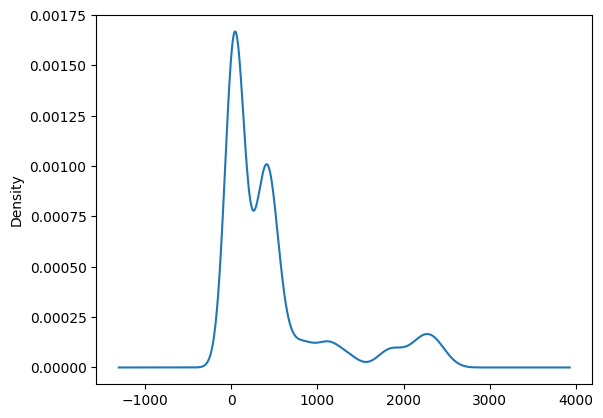

In [11]:
#Distribution of the dataset
df_close = stock_data['Price']
df_close.plot(kind='kde')

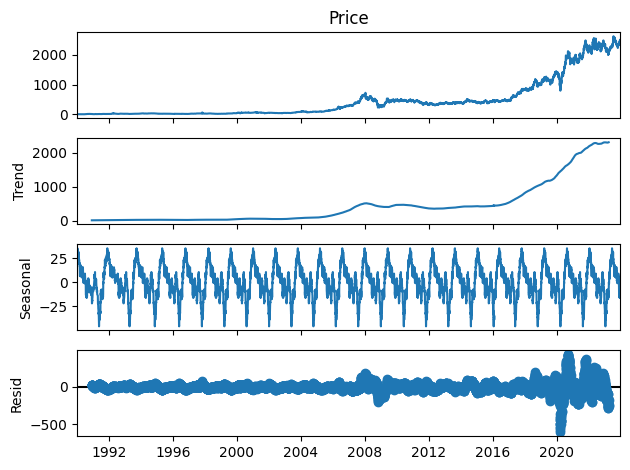

In [12]:
dec=seasonal_decompose(stock_data.Price,period=350)
dec.plot()
plt.show()

In [13]:
stock_data['Price'].describe()

count    8180.000000
mean      483.773132
std       651.354380
min         4.360000
25%        33.980000
50%       307.170000
75%       483.885000
max      2619.850000
Name: Price, dtype: float64

In [14]:
X = stock_data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=62.403694, mean2=905.142570
variance1=5352.210775, variance2=487964.708788


# Augmented Dickey fuller test.

In [15]:
def TestStationaryPlot(stock_data):
    rol_mean = stock_data.rolling(window = 20, center = False).mean()
    rol_std = stock_data.rolling(window = 20, center = False).std()
    
    plt.plot(stock_data, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Closing Price', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

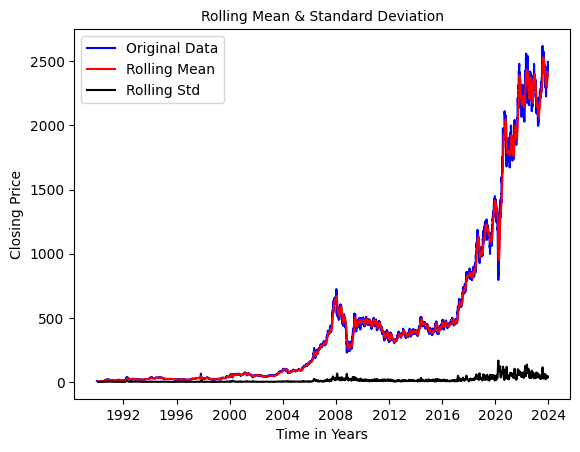

In [16]:
TestStationaryPlot(stock_data)

In [17]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(stock_data, cutoff = 0.01):
    stock_data_test = adfuller(stock_data, autolag = 'AIC')
    stock_data_test_output = pd.Series(stock_data_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    
    for key,value in stock_data_test[4].items():
        stock_data_test_output['Critical Value (%s)'%key] = value
    print(stock_data_test_output)
    
    if stock_data_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")
        

In [18]:
TestStationaryAdfuller(stock_data)

Test Statistic                    1.778975
p-value                           0.998306
Lags Used                        37.000000
Number of Observations Used    8142.000000
Critical Value (1%)              -3.431153
Critical Value (5%)              -2.861895
Critical Value (10%)             -2.566959
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


# Transforming Data into Stationary

# A) Moving Average Method

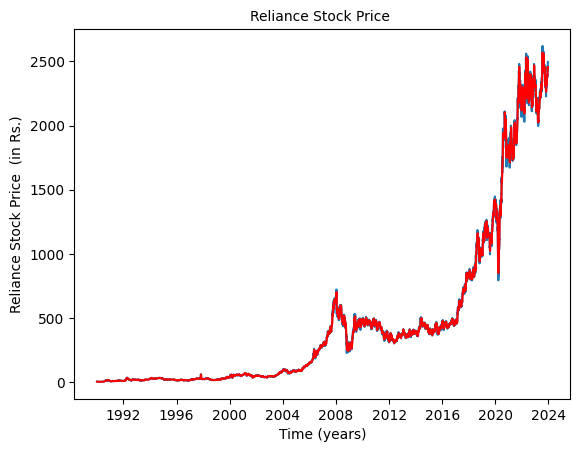

In [19]:
moving_avg = stock_data.rolling(5).mean()
plt.plot(stock_data)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (years)', fontsize = 10)
plt.ylabel('Reliance Stock Price  (in Rs.)', fontsize = 10)
plt.title('Reliance Stock Price ', fontsize = 10)
plt.show()

In [20]:
moving_avg_diff = stock_data - moving_avg
moving_avg_diff.head(15)

,Price
Date,
1990-01-02,NaN
1990-01-03,NaN
1990-01-04,NaN
1990-01-05,NaN
1990-01-08,-0.112
1990-01-09,-0.032
1990-01-10,0.218
1990-01-11,0.134
1990-01-15,-0.044


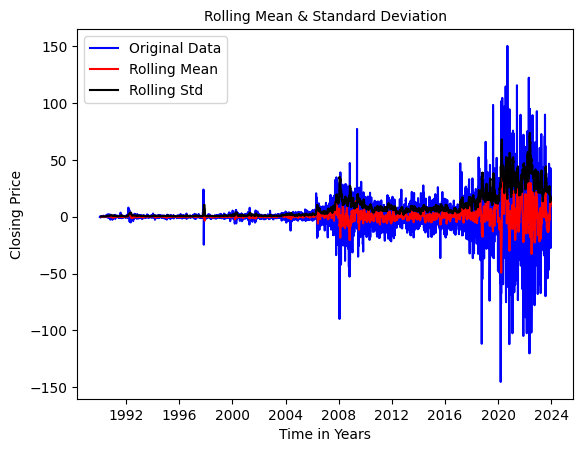

In [21]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [22]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                -1.537336e+01
p-value                        3.484460e-28
Lags Used                      3.700000e+01
Number of Observations Used    8.138000e+03
Critical Value (1%)           -3.431154e+00
Critical Value (5%)           -2.861895e+00
Critical Value (10%)          -2.566959e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


## First Order Differencing

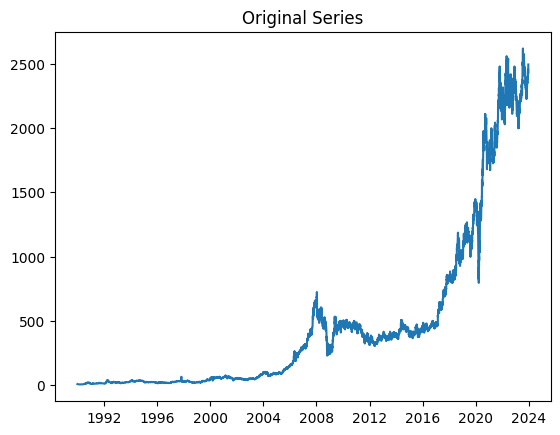

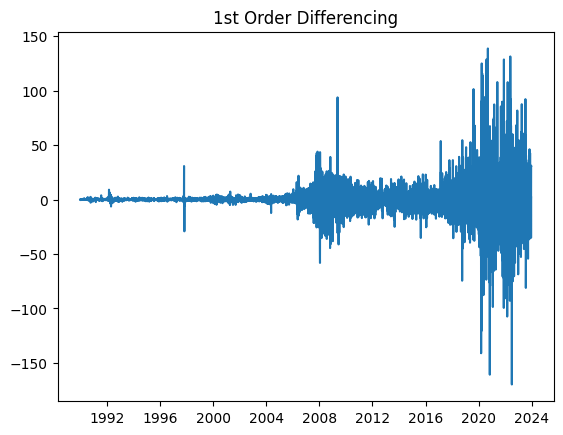

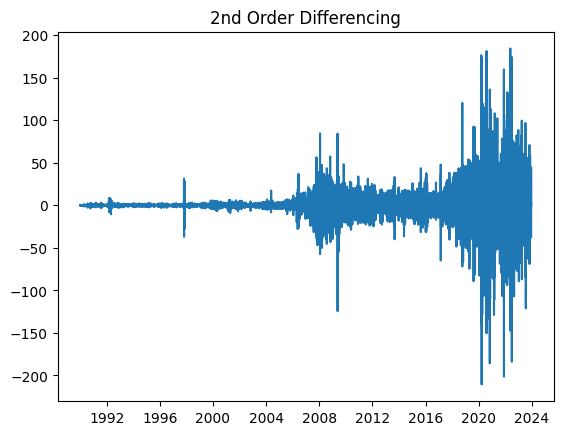

In [23]:
# Assuming 'stock_data' is your pandas Series/DataFrame containing the stock data

# Original Series
plt.plot(stock_data)
plt.title('Original Series')
plt.show()

# 1st Differencing
stock_data_first_difference = stock_data.diff()
plt.plot(stock_data_first_difference)
plt.title('1st Order Differencing')
plt.show()

# 2nd Differencing
stock_data_second_difference = stock_data.diff().diff()
plt.plot(stock_data_second_difference)
plt.title('2nd Order Differencing')
plt.show()


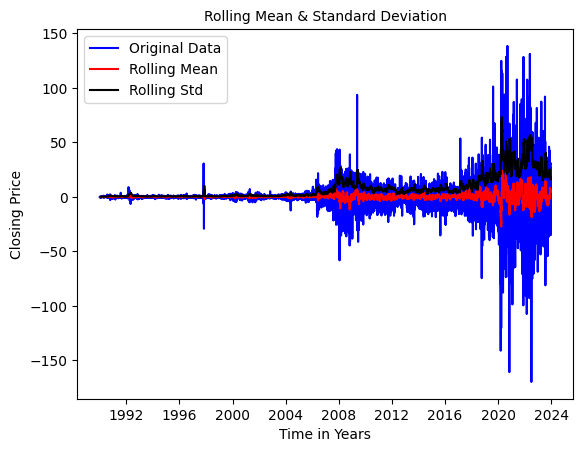

In [24]:
stock_data_first_difference = stock_data - stock_data.shift(1)  
TestStationaryPlot(stock_data_first_difference.dropna(inplace=False))

In [25]:
TestStationaryAdfuller(stock_data_first_difference.dropna(inplace=False))

Test Statistic                -1.639167e+01
p-value                        2.690456e-29
Lags Used                      3.600000e+01
Number of Observations Used    8.142000e+03
Critical Value (1%)           -3.431153e+00
Critical Value (5%)           -2.861895e+00
Critical Value (10%)          -2.566959e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


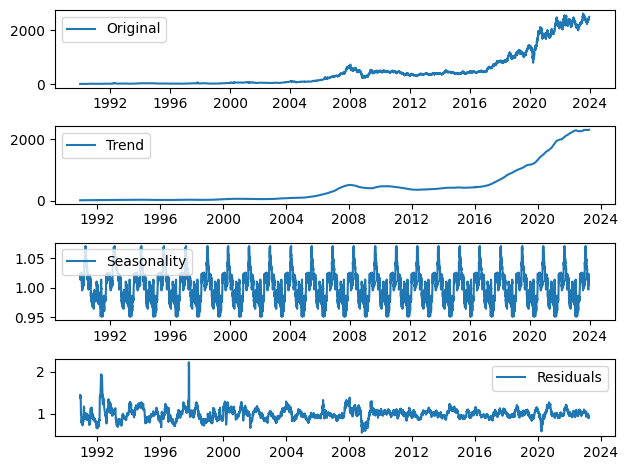

In [26]:
decomposition = seasonal_decompose(stock_data,period=350,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(stock_data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### ACF & PACF Plots

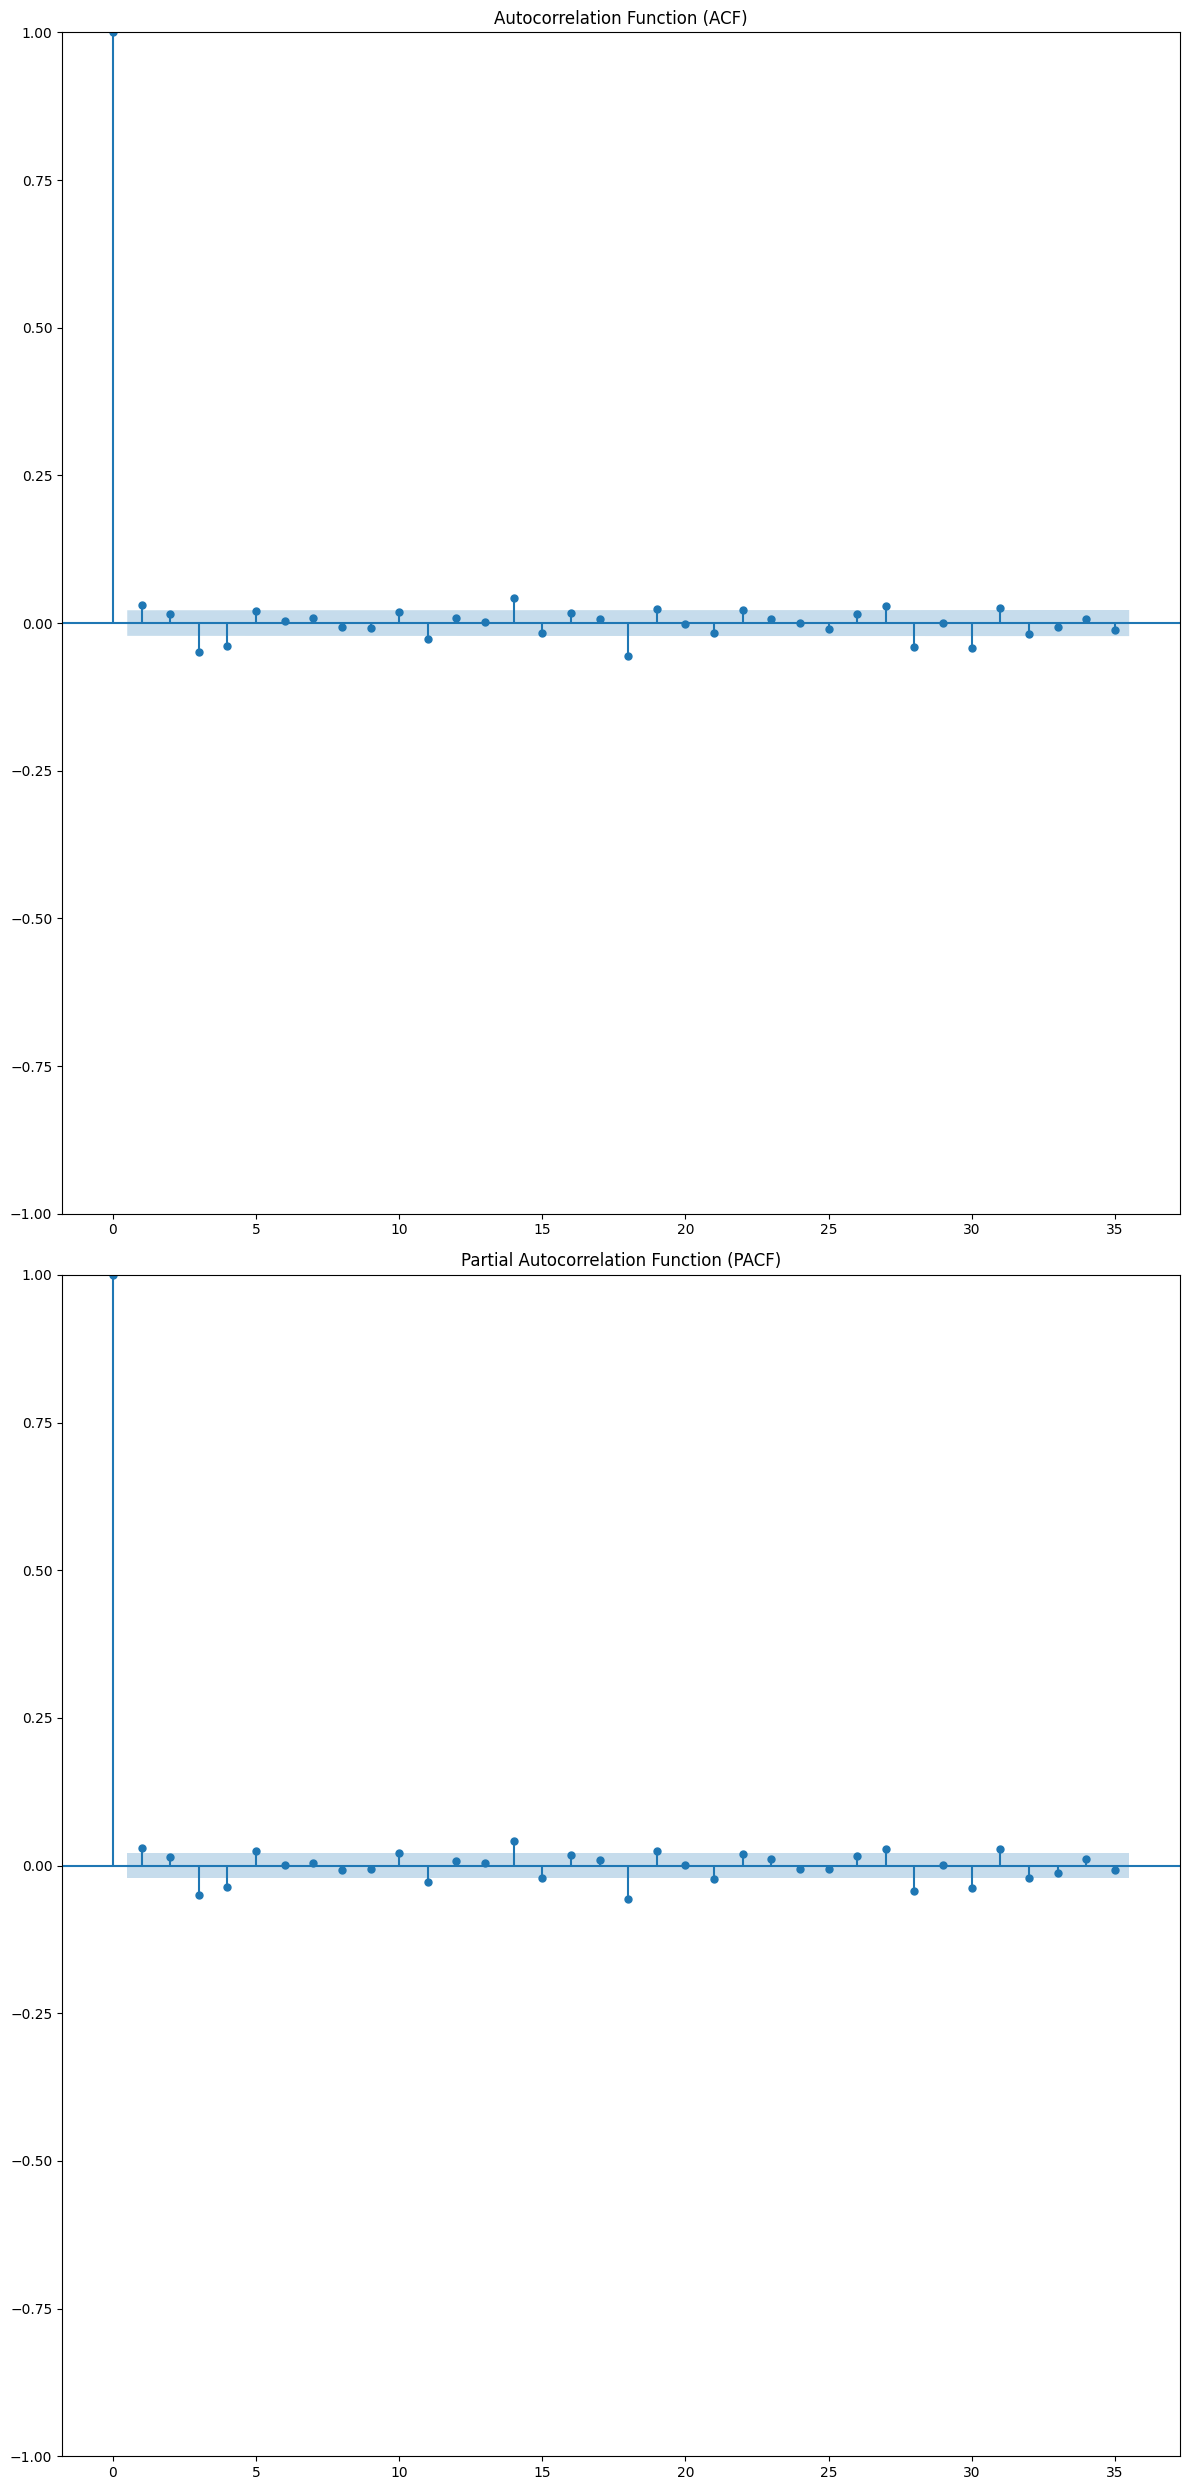

In [27]:
fig = plt.figure(figsize=(12, 25))  # Adjusting the figure size to fit both plots
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_data_first_difference.dropna(inplace=False), lags=35, ax=ax1)  # Change your_data_column to your actual data column
ax1.set_title('Autocorrelation Function (ACF)')

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_data_first_difference.dropna(inplace=False), lags=35, ax=ax2)  # Change your_data_column to your actual data column
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [28]:
# #if not stationary then eliminate trend
# #Eliminate trend
# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 6
# df_log = np.log(df_close)
# moving_avg = df_log.rolling(12).mean()
# std_dev = df_log.rolling(12).std()
# plt.legend(loc='best')
# plt.title('Moving Average')
# plt.plot(std_dev, color ="black", label = "Standard Deviation")
# plt.plot(moving_avg, color="red", label = "Mean")
# plt.legend()
# plt.show()

In [29]:
# #split data into train and training set
# train_data, test_data = df_log[3:int(len(df_log)*0.94)], df_log[int(len(df_log)*0.94):]
# plt.figure(figsize=(10,6))
# plt.grid(True)
# plt.xlabel('Year')
# plt.ylabel('Closing Prices')
# plt.plot(df_log, 'green', label='Train data')
# plt.plot(test_data, 'blue', label='Test data')
# plt.legend()

## Data Partitioning

In [30]:
train_data = stock_data.iloc[:-490]
test_data = stock_data.iloc[-490:]
train_data

,Price
Date,
1990-01-02,7.27
1990-01-03,6.92
1990-01-04,6.50
1990-01-05,6.71
1990-01-08,6.71
...,...
2021-12-20,2067.51
2021-12-21,2098.29
2021-12-22,2148.09


In [31]:
test_data

,Price
Date,
2021-12-27,2151.85
2021-12-28,2177.41
2021-12-29,2181.13
2021-12-30,2141.73
2021-12-31,2149.95
...,...
2023-12-11,2459.05
2023-12-12,2423.95
2023-12-13,2433.40


## Various ARIMA MODELs

## ARIMA(3,1,1)

In [32]:
# model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=17, max_q=17, # maximum p and q
#                       m=5,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)
# print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

In [39]:
# Build Model
model_arima = ARIMA(train_data['Price'],order = (3,1,1))
model_arima = model_arima.fit()
model_arima.summary()

/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/sumit/.l

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7690
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -29724.730
Date:                Wed, 20 Dec 2023   AIC                          59459.461
Time:                        23:15:28   BIC                          59494.199
Sample:                             0   HQIC                         59471.375
                               - 7690                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3070      0.073      4.190      0.000       0.163       0.451
ar.L2          0.0214      0.004      5.512      0.000       0.014       0.029
ar.L3         -0.0566      0.004    -13.898      0.000      -0.065      -0.049
ma.L1         -0.2911      0.074     -3.937      0.000      -0.436      -0.146
sigma2       133.4705      0.513    260.302      0.000     132.466     134.475
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            365428.52
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             214.63   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

7690    2151.677457
7691    2151.103301
7692    2150.485186
7693    2150.424229
7694    2150.424778
           ...     
8175    2150.475993
8176    2150.475993
8177    2150.475993
8178    2150.475993
8179    2150.475993
Name: predicted_mean, Length: 490, dtype: float64


/home/sumit/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [41]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 'rmse':rmse})

In [45]:
ns_arima_acc = forecast_accuracy(pred_arima.values, test_data.values)
ns_arima_acc

{'mape': 0.06682526146474246,
 'me': -145.96954235106676,
 'mae': 158.568307382899,
 'rmse': 192.9619643926453}

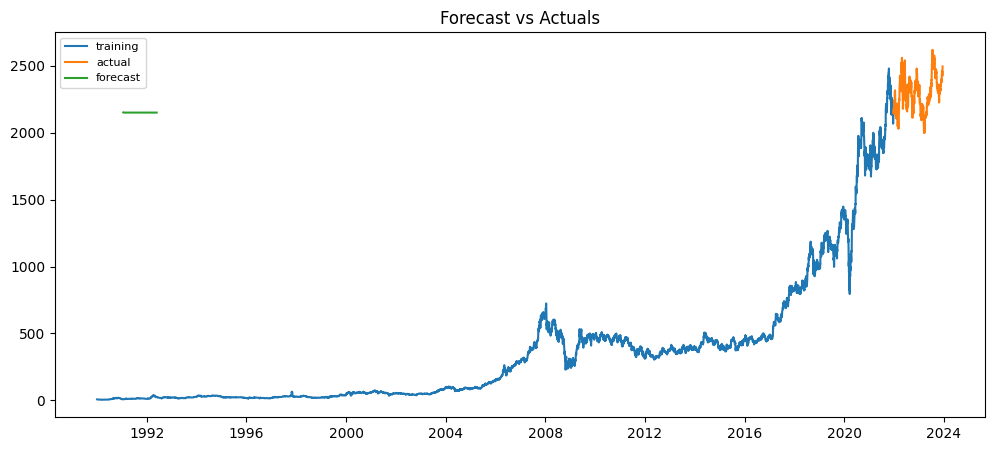

In [46]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')
plt.plot(pred_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

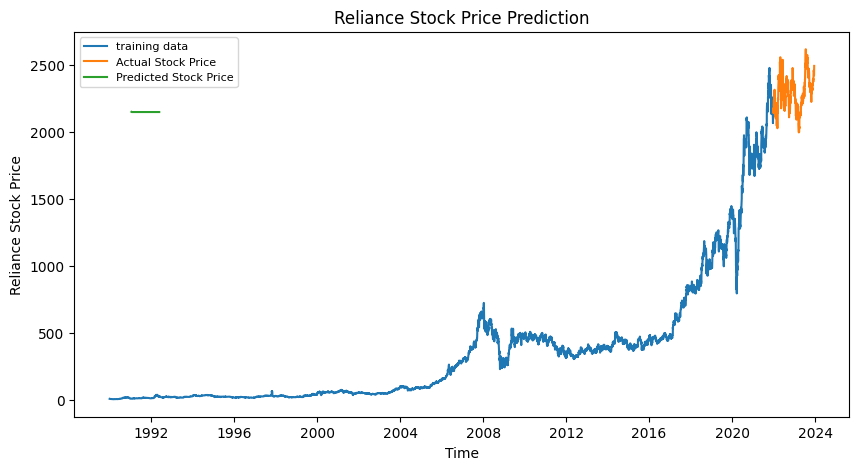

In [48]:
# Make a pandas series
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, label='Actual Stock Price')
plt.plot(pred_arima, label='Predicted Stock Price')
plt.title('Reliance Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Reliance Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()